In [1]:
# ruff: noqa: N802, N803, N806, N815, N816
import os

import numpy as np
import matplotlib.pyplot as plt

import archimedes as arc

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

# Part 1: System ID Basics

Let's dive right in with a simple example to see system identification in action, then we can backtrack to understand what's happening under the hood.

Here's what we'll cover:

1. Minimal example of estimating unknown system parameters from data
2. How the Prediction Error Method algorithm can be used for system identification
3. Why Kalman filters are useful for parameter estimation
4. Practical tips for troubleshooting and choosing an optimizer 

## Identifying a simple oscillator

Suppose you have some data from a step response test:

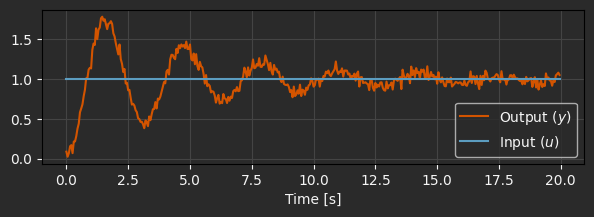

In [2]:
raw_data = np.loadtxt("data/oscillator.csv", skiprows=1, delimiter="\t")

data = arc.sysid.Timeseries(
    ts=raw_data[:, 0],
    us=raw_data[:, 1].reshape(1, -1),
    ys=raw_data[:, 2].reshape(1, -1),
)

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(data.ts, data.ys[0], label="Output ($y$)")
ax.plot(data.ts, data.us[0], label="Input ($u$)")
ax.set_xlabel("Time [s]")
ax.grid()
ax.legend()



Based on the frequency content and time series and your physical understanding of the system, you conclude that the system behaves like a classic second-order oscillator: a mass-spring-damper system:

$$
\ddot{x} + 2 \zeta \omega_n \dot{x} + \omega_n^2 x = \omega_n^2 u
$$

The two unknown parameters in this model are the natural frequency $\omega_n$ and the damping ratio $\zeta$.
Here's how Archimedes can help you identify these parameters.

In [3]:
# Define the system model
nx = 2  # Number of states
nu = 1  # Number of inputs
ny = 1  # Number of outputs

# Continuous-time dynamics
def oscillator_model(t, x, u, p):
    x1, x2 = x
    omega_n, zeta = p

    x1_t = x2
    x2_t = -omega_n**2 * x1 - 2*zeta*omega_n*x2 + omega_n**2 * u[0]

    return np.hstack([x2, x2_t])

# Discretize with an RK4 method using a zero-order hold
dt = data.ts[1] - data.ts[0]  # Time step
dyn = arc.discretize(oscillator_model, dt, method="rk4")

# Observation model
def obs(t, x, u, p):
    return x[0]

In [4]:
# Estimate the parameters of the system

# A simple way to estimate the noise variance is to use the
# variance of the differences of the output data - if the output
# was constant, this would give a good estimate of Gaussian noise.
noise_var = 0.5 * np.var(np.diff(data.ys[0]))

# Estimates of measurement and process noise covariance
R = noise_var * np.eye(ny)  # Measurement noise
Q = 1e-2 * noise_var * np.eye(nx)  # Process noise

# Don't worry about the Kalman filter for now; this will be explained
# later on in this page.
ekf = arc.observers.ExtendedKalmanFilter(dyn, obs, Q, R)

# Set up PEM problem
params_guess = np.array([2.5, 0.0])  # Initial guess for [omega_n, zeta]
result = arc.sysid.pem(
    ekf,
    data,
    params_guess,
    x0=np.zeros(nx),
)

print(f"Estimated natural frequency: {result.x[0]:.4f} rad/s")
print(f"Estimated damping ratio:     {result.x[1]:.4f}")

Iteration   Total nfev       Cost       Cost reduction   Step norm    Optimality 
    0           2         6.4925e-01                                   3.33e+00  
    1           3         5.0807e-01       1.41e-01       6.53e-01     1.69e-01  
    2           4         5.0692e-01       1.15e-03       5.89e-02     4.26e-04  
    3           5         5.0692e-01       7.31e-09       1.48e-04     3.83e-06  
Both actual and predicted relative reductions in the sum of squares are at most ftol
Estimated natural frequency: 1.9975 rad/s
Estimated damping ratio:     0.0923


That's it! In just a few lines, we've identified the unknown parameters of our physical system. The [`pem`](#archimedes.sysid.pem) function handles all the optimization, gradient calculations, and numerical details automatically.  This synthetic data was generated with $\omega_n = 2$ and $\zeta = 0.1$, so the estimated values are within 0.01 for both parameters after only 5 function evaluations and a fraction of a second.

A simple check on the accuracy of the model is to simulate it forward and compare the transients against the data:

Text(0.5, 1.0, 'Step response')

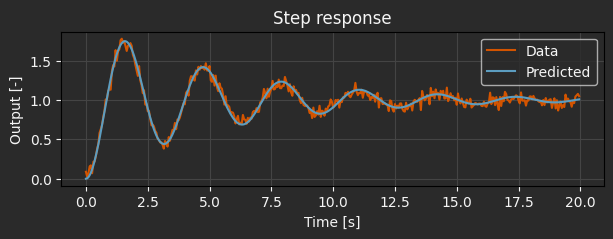

In [5]:
# Predicted step response with optimized parameters
# Note that if the input was time-varying we would need to interplolate it
# for the simulation (see the Duffing example).
xs_pred = arc.odeint(
    oscillator_model,
    t_span=(data.ts[0], data.ts[-1]),
    x0=np.zeros(nx),
    args=(data.us[0, :], result.x),
    t_eval=data.ts,
    rtol=1e-8,
    atol=1e-10,
)

ys_pred = xs_pred[0]

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(data.ts, data.ys.squeeze(), label="Data")
ax.plot(data.ts, ys_pred, label="Predicted")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Output [-]")
ax.grid()
ax.legend()
ax.set_title("Step response")

Of course, for a truly linear system the step response fully characterizes the behavior, so in principle this is all the "validation" we need.

More generally this is not safe to assume, and so the model should be carefully evaluated on different data.
We'll see examples of some basic validation strategies later in this tutorial.

But before moving on to more advanced examples, let's take a step back and take a closer look at what's actually happening in this code.

## The Prediction Error Method (PEM)

This example uses an algorithm called the "Prediction Error Method" (PEM).
The core idea is simple:

1. **Build a predictive model** of your system (`oscillator_model`)
2. **Compare predictions to measurements** and compute the error
3. **Adjust parameters** to minimize this prediction error

The typical formulation is to solve the least-squares optimization problem

$$
\min_p \sum_{k=1}^N ||y_k - \hat{y}_k(p)||^2,
$$

where $p$ are model parameters to be tuned, $y_k$ is the set of measurements at time step $k$, and $\hat{y}_k(p)$ are the model predictions for the same time step using the current parameters.

This formulation is highly flexible and can handle:

- Linear or nonlinear models
- Known physics and data-driven "black-box" components
- Input/output or output-only time series
- Stochastic systems with process and measurement noise
- Bounds on the system parameters
- Data from multiple experiments
- General nonlinear constraints

To understand what's happening in the example above, we'll go through the elements of the PEM one at a time and see how they relate to the code.

### 1. State-space models

We will consider problems of the general discrete-time stochastic state-space form:

\begin{align}
x_{k+1} &= f(t_k, x_k, u_k; p) + w_k \\
y_k &= h(t_k, x_k, u_k; p) + v_k,
\end{align}

where $t$ is the time, $x$ are the system states, $u$ are the control inputs, and $p$ are the system parameters.
The process noise $w$ and measurement noise $v$ are assumed to be Gaussian-distributed with covariance matrices $Q$ and $R$, respectively.
We will refer to $f$ as the "dynamics" function and $h$ as the "observation" function.

In the code above, the dynamics model is implemented as a continuous-time ODE `oscillator_model`, and the simple observation function is implemented in `obs`:

```python
# Continuous-time dynamics
def oscillator_model(t, x, u, p):
    x1, x2 = x
    omega_n, zeta = p

    x1_t = x2
    x2_t = -omega_n**2 * x1 - 2*zeta*omega_n*x2 + omega_n**2 * u[0]

    return np.hstack([x2, x2_t])

# Observation model
def obs(t, x, u, p):
    return x[0]
```

Commonly, the most natural representation of physical dynamics is as a continuous ordinary differential equation or differential algebraic equation; in these cases the model can be transformed to a discrete-time system using the [`discretize`](#archimedes.discretize) function, which applies a zero-order hold to inputs and uses implicit or explicit Runge-Kutta methods to advance the differential equation.
This is exactly how the `oscillator_model` ODE function is transformed into the discrete-time difference equation `dyn` in the code above:

```python
dyn = arc.discretize(oscillator_model, dt, method="rk4")
```

Your predictive model consists of implementations of the dynamics function $f$ (`dyn` above) and the observation function $h$ (`obs` above).
The choice of how to mathematically model your dynamical system is _critical_ to successful system identification.
However, since this is usually highly domain- and even problem-specific, in this tutorial series we won't focus on how to do this, although we will give some general best practices in [Part 4](sysid04.md).
For now we'll assume that the model structure is either known or obvious so that we can focus on the mechanics of the parameter estimation.

**Implementation note:** One important thing to remember is that both your dynamics and observation functions _must_ be compatible with symbolic tracing in Archimedes in order to efficiently compute the gradients of the PEM objective using automatic differentiation ("autodiff").
The code above _looks_ like standard NumPy, but behind the scenes Archimedes will evaluate it symbolically and convert it into a C++ computational graph that's compatible with autodiff.

This can result in some minor differences with how you might usually write code.
For example, due to the interaction between the NumPy array API and symbolic tracing in Archimedes, the return from `oscillator_model` cannot be the usual `np.array([x2, x2_t])`, although we can replace this easily enough with `np.hstack([x2, x2_t])` for almost the same effect.
For details on why this happens and what to do about it, see the [Getting Started](../../getting-started.md) guide or [Quirks and Gotchas](../../gotchas.md).

## 2. Generating predictions

Once we have the predictive model in discrete-time state-space form as shown above, in principle we could generate predictions by simply running the model forward:

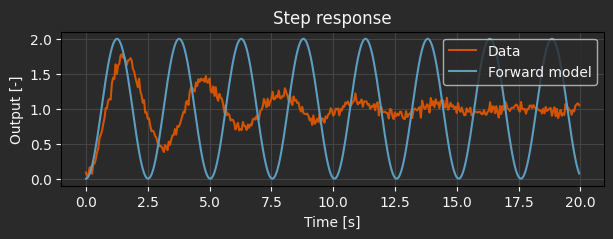

In [6]:
# Predicted step response with initial guess parameters

def forward(data, params, x0):
    ys_pred = np.zeros_like(data.ys)
    xs_pred = np.zeros((nx, len(data.ts)))
    xs_pred[:, 0] = x0  # Initial state
    for i in range(1, len(data.ts)):
        xs_pred[:, i] = dyn(data.ts[i], xs_pred[:, i - 1], data.us[:, i - 1], params)
        ys_pred[:, i] = obs(data.ts[i], xs_pred[:, i], data.us[:, i - 1], params)

    return ys_pred

ys_fwd = forward(data, params_guess, x0=np.zeros(nx))

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(data.ts, data.ys[0], label="Data")
ax.plot(data.ts, ys_fwd[0], label="Forward model")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Output [-]")
ax.grid()
ax.legend(loc="upper right")
ax.set_title("Step response")
plt.show()

There are two main problems with this.

1. **Noise:** This approach to prediction is not capable of treating either measurement noise or inherent stochasticity in a principled way.
2. **Drift:** Even if the model is slightly wrong (for instance a small error in frequency), over time the predictions will significantly deviate, and there is no way to recover.

For relatively clean data from a deterministic system with approximately Gaussian noise, the first of these problems is often not that bad in practice.
However, the drift problem can make the underlying optimization problem very difficult to solve.
This issue also becomes _significantly_ worse if the underlying system is stochastic, unstable, or chaotic, or when optimizing over long time series.

For a great intuitive explanation of the difficulties with simply simulating the model forward, check out [this video](https://youtu.be/l9oJKxKivW8?si=ustU3WIxjg-7AFS0) from JuliaHub's Fredrik Bagge Carlson.

### Kalman filters

The PEM implementation in Archimedes instead uses a [_Kalman filter_](https://en.wikipedia.org/wiki/Kalman_filter) for the predictor model.

You may be familiar with Kalman filtering in the context of control systems, where they are typically used for full-state estimation.
This enables design of state-feedback controllers like a linear-quadratic regulator, which can be more effective for partially observed systems than output-only feedback.

The filters used in the prediction error method are identical to the state estimation formulation.
For linear systems the Kalman filter gives an _optimal_ state estimate accounting for the Gaussian noise, and under some assumptions can be proven to converge to the true state.

The key idea of the filter is to maintain a state estimate $\hat{x}$ that is updated via a feedback mechanism with incoming measurements.
The insight is that the forward prediction approach discussed above is essentially running in "open-loop"; starting from the initial state, the model runs forward in time without making use of any measurement data.
The Kalman filter on the other hand compares model predictions to incoming measurements to refine the state estimate, creating a "closed-loop" predictor architecture.
Specifically, for each new measurement $y_k$, the _innovation_ $e_k = y_k - \hat{y}_k$ is calculated and used to correct the state estimate by

$$
\hat{x}_{k+1} = f(t_k, \hat{x}_k, u_k) + K_k e_k.
$$

<!-- PLACHOLDER: Block diagram representation of Kalman filter -->
```{image} _static/placeholder.png
:class: only-light
```

```{image} _static/placeholder.png
:class: only-dark
```

The Kalman gain matrix $K_k$ is generally time-varying and helps to account for the noise and estimation errors in an optimal way.

For nonlinear systems, the Kalman filter can be generalized to the _Extended_ Kalman filter (EKF) by simply linearizing about the current state estimate.
This loses the strict guarantees of the linear filter, but is still highly robust and widely used in practical control applications.
For more strongly nonlinear systems, an _Unscented_ Kalman filter may perform even better.

These filters are useful in system identification for several reasons:

1. They provide a principled way of quantifying uncertainty and dealing with sources of noise.
2. They can use measurements to "steer" predictions towards the true value, smoothing out the cost landscape and reducing drift over long time series.
3. The probabilistic prediction models allow for alternative formulations like maximum likelihood estimation.

The Kalman filters in Archimedes live in the [`archimedes.observers`](#archimedes.observers) module and are constructed as above using the dynamics and observation model, plus estimated noise covariance matrices `Q` (for process noise/stochasticity) and `R` (for measurement/sensor noise).

```python
ekf = arc.observers.ExtendedKalmanFilter(dyn, obs, Q, R)
```

If these covariances are unknown, we will give some practical suggestions for reasonable estimates in [Part 4](sysid04.md).
As shown above, a simple approach to estimating noise levels in time series with sampling rates that are high compared to the frequency content is to ignore signal variation and estimate noise based on step-to-step variance:

```python
noise_var = 0.5 * np.var(np.diff(data.ys[0]))
```

The Kalman filters share a common interface: advancing with a `step` method that has the following signature:

```raw
step(t, x, y, P, args) -> x_next, P_next, e,
```

where `t`, `x`, `y`, and `P` are the current time, state estimate, incoming measurement, and covariance matrix.
The optional `args` argument includes any arguments expected by the dynamics and observation models besides `t` and `x`.
In the context of the prediction error method, these functions will also need the inputs `u` and parameters `p`, so we will include a tuple `args = (u, p)` at every step.

The returns `x_next` and `P_next` are the state and covariance estimates advanced one step in time, and the _innovation_ `e` is $y_k - \hat{y}_k`, the residual difference between the predicted and actual measurement.

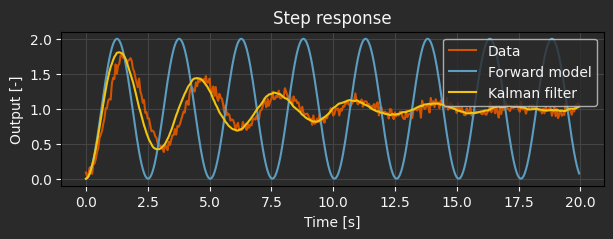

In [7]:
# Run the model forward with a Kalman filter

P = 1e-4 * np.eye(nx)  # Initial covariance (small for known state)
x_hat = np.zeros((nx, len(data.ts)))  # State estimate

# Compile the step function for faster execution
ekf_step = arc.compile(ekf.step)
for k in range(1, len(data.ts)):
    args = (data.us[0, :], params_guess)
    x_hat[:, k], P, e = ekf_step(
        data.ts[k], x_hat[:, k-1], data.ys[:, k-1], P, args=args
    )

y_hat = x_hat[0:1, :]  # Simple observation model in this case

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(data.ts, data.ys[0], label="Data")
ax.plot(data.ts, ys_fwd[0], label="Forward model")
ax.plot(data.ts, y_hat[0], label="Kalman filter")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Output [-]")
ax.grid()
ax.legend(loc="upper right")
ax.set_title("Step response")
plt.show()

With the same parameters as the forward model, the Kalman filter tracks the true measurements much more closely.  Of course, the match is not perfect - this is actually good, since we _want_ a mismatch for incorrect parameters in order to give us an error to optimize in the parameter estimation problem.  And critically, the Kalman filter error will still go to a minimum at the correct parameters, so adding this layer to the optimizer does not risk "moving" the parameters away from the optimum.  Intuitively, "steering" the state estimate closer to the real solution in this way can help smooth out the optimization landscape and make it easier for the optimizer to converge.

As an added bonus, once the optimal parameters are identified, you get a state estimator for free!

## 3. Solving the optimization problem

With our state-space model and Kalman filter predictor, the full PEM formulation of the system ID problem is

\begin{gather}
\min_p \sum_{k=1}^N ||y_k - \hat{y}_k||^2.
\end{gather}

Bounds may also be added on the parameters, and the objective may be further customized as needed (see for example [Part 3](
../../generated/notebooks/sysid/sysid03) of this series).


This is a nonlinear optimization problem which can be solved using least-squares methods like the Gauss-Newton or Levenberg-Marquardt algorithms.
Alternatively, it can be treated as a nonlinear programming problem and solved with general-purpose solvers like BFGS or IPOPT.
However, all of these require the gradient (and possibly the Hessian) of the objective function, which is difficult and error-prone to manually implement as a result of the complex recursive structure of the PEM objective.

Fortunately, Archimedes can leverage the highly efficient automatic differentiation capabilities of CasADi for gradient and (if needed) Hessian calculations.
This means that, as long as you implement your models within the scope of supported operations in Archimedes, you won't have to think about derivatives at all.

Derivative calculations are handled automatically through the interfaces in the [`optimize`](#archimedes.optimize) module, including [`least_squares`](#archimedes.optimize.least_squares) and [`minimize`](#archimedes.optimize.minimize).

The least-squares interface includes wrappers for the SciPy methods `"lm"` (the MINPACK implementation of Levenberg-Marquardt) and `"trf"` (a trust-region reflective algorithm that supports bounds), as well as `"hess-lm"`, a custom Levenberg-Marquardt implementation that supports bounds by switching to the [OSQP](https://osqp.org/) quadratic programming solver.

Similarly, the `minimize` interface supports both CasADi solvers (SQP and IPOPT) and provides a wrapper to SciPy optimizers like BFGS, automatically constructing gradient and Hessian functions as necessary. 

### Code interface

There are two interfaces for solving system ID problems with the prediction error method: a high-level [`pem`](#archimedes.sysid.pem) function that will set up the optimization problem and call an appropriate solver, or a set of lower-level interfaces that can be used for additional customization.

The high-level [`pem`](#archimedes.sysid.pem) interface requires a predictor model (e.g. a Kalman filter with supplied dynamics and observation functions), a dataset to train on, and an initial guess for the parameters to be estimated.
If known, the initial state can also be provided (otherwise it will also be estimated as part of the optimization).
Upper and lower bounds can also be supplied for each parameter (or set to `np.inf` if unbounded).

```python
result = arc.sysid.pem(
    ekf, data, params_guess, x0=x0, bounds=bounds, method=method
)
```

The function will construct an appropriate objective function and call the optimization method specified via the keyword arg (e.g. `"lm"` or `"bfgs"`).

If more control and customization is needed, you can manually create a [`PEMObjective`](#archimedes.sysid.PEMObjective) object that can calculate residuals.  This can then be combined with other objective functions or nonlinear constraints to create advanced system ID workflows.
A simple example of using this low-level interface with multi-experiment data will be covered in [Part 3](
../../generated/notebooks/sysid/sysid03) of this series.


### General `method` recommendations

1. If you do not have nonlinear constraints, least-squares solvers are typically more efficient.
2. The MINPACK Levenberg-Marquardt solver (`"lm"`) is a good place to start for unbounded problems.  The other least-squares solvers perform relatively similarly for problems with bounds, but you may want to experiment with both `"hess-lm"` and `"trf"`.
3. If you include general constraints (such as global energy conservation or enforcing certain equilibrium points) then you need to switch to a nonlinear programming solver; `"ipopt"` is a good first choice.

If the solver you choose is struggling to converge reliably, you can try others, but it is also quite likely you may want to try modifying your problem formulation or improving your initial parameter estimate.

## Troubleshooting and Tips

As a general rule, system identification problems can become challenging numerical optimization problems as a result of the complex nonlinearities and recursive structure.
What this means for you is that anything you can do to help the optimizer will greatly improve your odds of success.
If the solver is not giving good parameter estimates, you may need to invest some time in improving your setup, which can be done in a few ways:

1. **Model structure:** If the "optimized" models are not giving good results, the first question you should ask is whether the model is really appropriate for your application.  Can you include any additional domain knowledge?  Can you use a simpler model to avoid over-parameterization?  Are there any sanity checks you can do to convince yourself that the model has the capacity to accurately describe the system?

2. **Initial guess:** The cost landscapes for system identification problems can be riddled with local minima, meaning that it is easy for the optimizer to converge to suboptimal solutions.  The best remedy for this is to invest some time in a reliable procedure for improving your initial guess.  This could be some problem-specific heuristic for getting close, or it could be some brute-force approach like a coarse grid search.

3. **Time-series length:** One common reason for non-convexity in the cost landscape is long time series.  If your data is "long" (say, 100 or more times the longest important time scales of the system) you may want to consider taking a "multiple shooting" approach and dividing the data into multiple smaller time series.  At the moment, multi-experiment identification isn't supported through the high-level `pem` interface, but see [Part 3](
../../generated/notebooks/sysid/sysid03) of this series for an example of how to create custom optimization problems.

4. **Pre-processing:** Data quality can also have an outsized impact on system identification efficacy.  Is there any bias or drift in the measurements?  Does the noise appear Gaussian?  Can you filter any outliers?  Sometimes data pre-processing can help dramatically.

5. **Parameter bounds:** While generally not as effective as a better initial guess, reasonable parameter bounds can lead to better outcomes in some cases.  This is also critical if the optimizer is crashing because of unphysical parameter values like negative mass.

6. **Additional information:** This is where you might need to get creative.  What else do you know about your system that isn't currently encoded in the optimization problem?  Do you have any additional data that could be incorporated?  How might you customize your model or optimization problem to include this?

Unfortunately, while linear system identification tends to "just work", part of the challenge with nonlinear system ID is that there's no one-size-fits all solution.
The best model parameterization and problem formulation is often problem-specific, so building up a good workflow for system identification can take some time investment and can have a learning curve.
The payoff is that if you _do_ make the investment and develop a reliable system ID workflow, you can automatically calibrate and re-calibrate your models based on new data or design changes with minimal incremental effort.